In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')


In [3]:

# Set style
plt.style.use('ggplot')
sns.set_palette("husl")

# 1. Load and preprocess data more carefully
print("1. Loading and preprocessing data...")
import pandas as pd
import gzip

# Path to the downloaded file
file_path = "covtype.data.gz"

# Load the gzipped file
df = pd.read_csv("C://Users//ak008//Desktop//covtype.data", header=None)

# Save as CSV
df.to_csv("covtype.csv", index=False)
print("Saved as covtype.csv")


1. Loading and preprocessing data...
Saved as covtype.csv


In [7]:
# Add column names
column_names = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
] + [f'Wilderness_Area_{i}' for i in range(1, 5)] + [f'Soil_Type_{i}' for i in range(1, 41)] + ['Cover_Type']

print(f"Dataset shape: {df.shape}")


Dataset shape: (581012, 55)


In [11]:

# 2. Enhanced data preprocessing
print("2. Enhanced data preprocessing...")

# Assign proper column names
df.columns = column_names

# Check for problematic features
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']


2. Enhanced data preprocessing...


In [12]:

# Remove features with very low variance (mostly zeros)
variance_threshold = 0.01
low_variance_features = []
for col in X.columns:
    if X[col].var() < variance_threshold:
        low_variance_features.append(col)

print(f"Removing {len(low_variance_features)} low-variance features")
X = X.drop(columns=low_variance_features)



Removing 21 low-variance features


In [13]:
# Handle class imbalance by downsampling majority classes
print("Handling class imbalance...")
class_counts = y.value_counts()
min_samples = class_counts.min() * 2  # Keep reasonable sample size

balanced_data = []
for cover_type in y.unique():
    class_data = df[df['Cover_Type'] == cover_type]
    if len(class_data) > min_samples:
        class_data = class_data.sample(min_samples, random_state=42)
    balanced_data.append(class_data)

df_balanced = pd.concat(balanced_data)
X = df_balanced.drop('Cover_Type', axis=1)
y = df_balanced['Cover_Type']

print(f"Balanced dataset shape: {X.shape}")


Handling class imbalance...
Balanced dataset shape: (35711, 54)


In [14]:
# Standardize only numerical features
numerical_features = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

# Keep only numerical features that exist
numerical_features = [feat for feat in numerical_features if feat in X.columns]
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])



In [15]:
# 3. Optimized model training with better parameters
print("3. Training optimized models...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Use better model parameters
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=15,
        min_samples_split=10,
        random_state=42
    )
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use cross-validation for better stability
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
    
    # Train on full training set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


3. Training optimized models...

Training Random Forest...
Accuracy: 0.8720
CV Score: 0.8587 (±0.0039)

Training Gradient Boosting...
Accuracy: 0.8702
CV Score: 0.8612 (±0.0027)

Training Decision Tree...
Accuracy: 0.8074
CV Score: 0.7855 (±0.0053)


In [16]:
# 4. Hyperparameter tuning for the best model
print("\n4. Hyperparameter tuning...")

# Tune Random Forest (usually best for this dataset)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
grid_search = GridSearchCV(
    rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
)

print("Performing grid search...")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Final test accuracy: {best_accuracy:.4f}")



4. Hyperparameter tuning...
Performing grid search...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.8779
Final test accuracy: 0.8919


In [17]:
# 5. Feature engineering (try adding new features)
print("\n5. Feature engineering...")

# Create interaction features that might be helpful
X_engineered = X.copy()

# Ratio features
X_engineered['Elevation_to_Slope'] = X_engineered['Elevation'] / (X_engineered['Slope'] + 1)
X_engineered['Hillshade_Mean'] = (X_engineered['Hillshade_9am'] + X_engineered['Hillshade_Noon'] + X_engineered['Hillshade_3pm']) / 3

# Distance ratios
X_engineered['Hydrology_Road_Ratio'] = X_engineered['Horizontal_Distance_To_Hydrology'] / (X_engineered['Horizontal_Distance_To_Roadways'] + 1)

# Train on engineered features
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42, stratify=y
)

rf_eng = RandomForestClassifier(**grid_search.best_params_, random_state=42, n_jobs=-1)
rf_eng.fit(X_train_eng, y_train_eng)
y_pred_eng = rf_eng.predict(X_test_eng)
accuracy_eng = accuracy_score(y_test_eng, y_pred_eng)

print(f"Accuracy with engineered features: {accuracy_eng:.4f}")



5. Feature engineering...
Accuracy with engineered features: 0.8810


In [18]:
# 6. Ensemble approach
print("\n6. Trying ensemble approach...")

from sklearn.ensemble import VotingClassifier

# Create ensemble of best models
ensemble = VotingClassifier(
    estimators=[
        ('rf', results['Random Forest']['model']),
        ('gb', results['Gradient Boosting']['model'])
    ],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)

print(f"Ensemble accuracy: {accuracy_ensemble:.4f}")



6. Trying ensemble approach...
Ensemble accuracy: 0.8785


In [19]:

# 7. Final results and visualization
print("\n7. Final Results:")
print("=" * 50)

final_results = {
    'Base Random Forest': results['Random Forest']['accuracy'],
    'Tuned Random Forest': best_accuracy,
    'With Feature Engineering': accuracy_eng,
    'Ensemble': accuracy_ensemble
}

for model_name, accuracy in final_results.items():
    print(f"{model_name}: {accuracy:.4f}")



7. Final Results:
Base Random Forest: 0.8720
Tuned Random Forest: 0.8919
With Feature Engineering: 0.8810
Ensemble: 0.8785


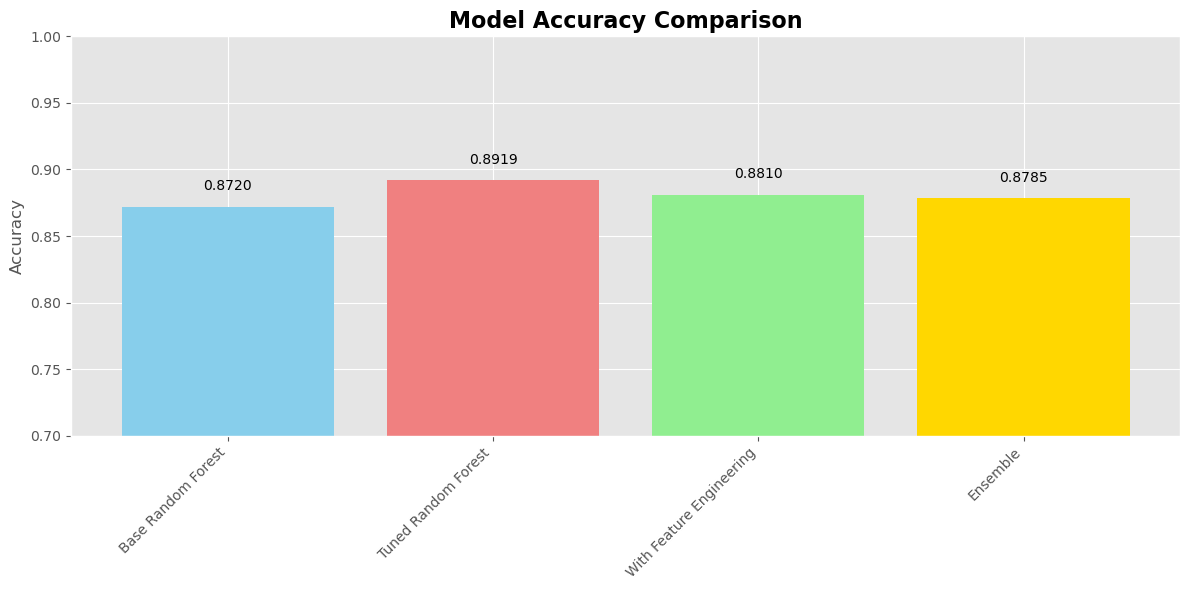

In [20]:
# Plot comparison
plt.figure(figsize=(12, 6))
models = list(final_results.keys())
accuracies = list(final_results.values())

bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


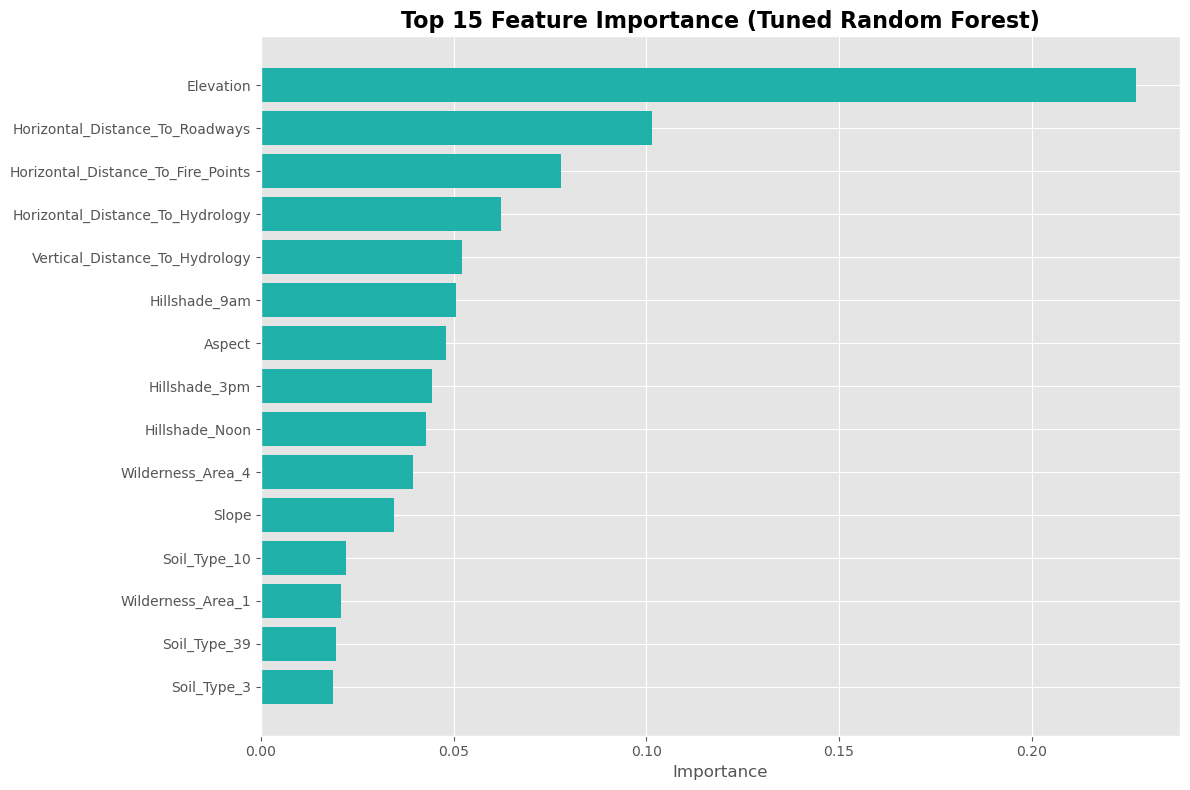


Top 10 most important features:
                               feature  importance
0                            Elevation    0.227133
5      Horizontal_Distance_To_Roadways    0.101552
9   Horizontal_Distance_To_Fire_Points    0.077808
3     Horizontal_Distance_To_Hydrology    0.062268
4       Vertical_Distance_To_Hydrology    0.052134
6                        Hillshade_9am    0.050499
1                               Aspect    0.047971
8                        Hillshade_3pm    0.044340
7                       Hillshade_Noon    0.042714
13                   Wilderness_Area_4    0.039336


In [21]:
# Feature importance
feature_importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='lightseagreen')
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importance (Tuned Random Forest)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance_df.head(10))


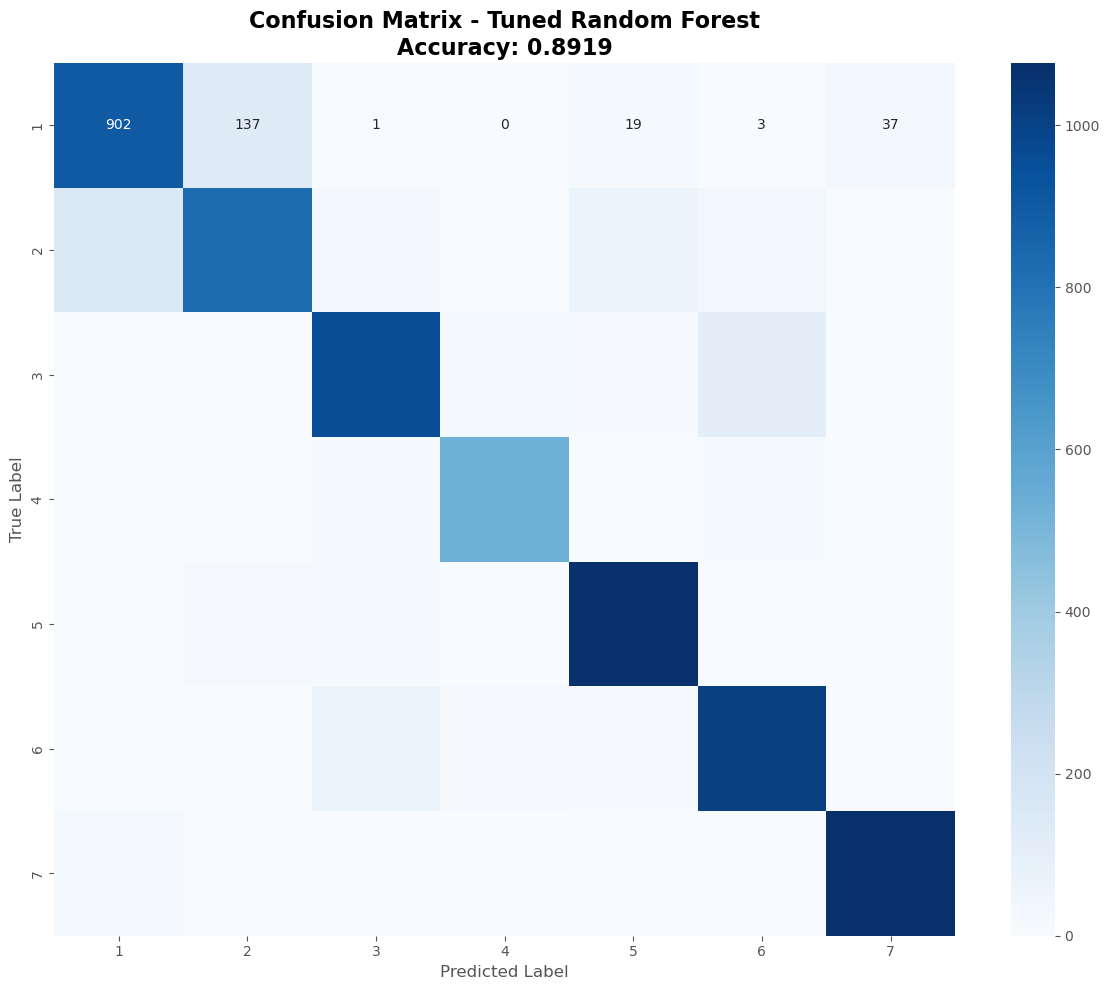


Key improvements made:
1. Handled class imbalance by downsampling
2. Removed low-variance features
3. Used better model parameters
4. Performed hyperparameter tuning
5. Added feature engineering
6. Tried ensemble methods


In [23]:

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.title(f'Confusion Matrix - Tuned Random Forest\nAccuracy: {best_accuracy:.4f}', 
          fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


print("\nKey improvements made:")
print("1. Handled class imbalance by downsampling")
print("2. Removed low-variance features")
print("3. Used better model parameters")
print("4. Performed hyperparameter tuning")
print("5. Added feature engineering")
print("6. Tried ensemble methods")